In [1]:
using Plots
using LinearAlgebra
using Revise
using NeuralVerification
using NeuralVerification:Network, Layer, ReLU, Id, read_nnet, compute_output
using LazySets
using Random
using BlackBoxOptim
include("unicycle_env.jl")
include("controller.jl")
include("problem.jl")
include("safe_set.jl")

┌ Info: Precompiling NeuralVerification [146f25fa-00e7-11e9-3ae5-fdbac6e12fa7]
└ @ Base loading.jl:1278
┌ Warning: Package NeuralVerification does not have CPLEX in its dependencies:
│ - If you have NeuralVerification checked out for development and have
│   added CPLEX as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with NeuralVerification
└ Loading CPLEX into NeuralVerification from project dependency, future warnings for NeuralVerification are suppressed.


grad_phi (generic function with 2 methods)

In [2]:
net_path = "../nnet/unicycle-FC3-100-rk4/epoch_1000.nnet"
net = read_nnet(net_path);
obs_radius = 0.5

0.5

In [3]:
function generate_moving_target(;fps=10, tf=2, v=nothing, v_lim=0.5)
    T = tf*fps
    v = isnothing(v) ? [rand(), rand()]*v_lim*2 .- v_lim : v
    p = [0, 1.5]
    return [Obstacle(p+v*(i/fps), v, obs_radius) for i in 0:T-1]
end

function get_Xref(x0, xg, T, dt)
    tf = T*dt
    dp = [xg[1]-x0[1], xg[2]-x0[2]]
    da = xg[4]-x0[4]
    a = atan(dp[2], dp[1])
    v = norm(dp)/tf
    v = max(min(v, 1),-1)
    vx = v * cos(a)
    vy = v * sin(a)
    Xref = [[x0[1]+vx*k*dt, x0[2]+vy*k*dt, v, a] for k = 1:T]
    Xref[end][3] = 0
    return Xref
end

function tracking(rp::RP, ctrl; fps=10, tf=2, obstacles=nothing, safety_index=nothing, verbose=false)
    T=Int(ceil(fps*tf))
    dt=1.0/fps
    x = rp.x0
    X = [copy(rp.x0) for k = 1:T]
    U = [zeros(2) for k = 1:T-1]
    safe_sets = []
    Xrefs = []
    tot_time = 0
    col_cnt = 0
    infeas=false
    for i in 1:T-1
        Xref = get_Xref(x, rp.xg, fps, dt)
        xref = Xref[1]
        push!(Xrefs, Xref)
        timed_result = @timed get_control(ctrl, xref, x, rp.net, rp.obj_cost, dt, obstacles=obstacles, safety_index=safety_index)
        u, safe_set = timed_result.value
        dot_x = compute_output(net, [x; u])
        if !(dot_x ∈ safe_set)
            infeas=true
        end
        push!(safe_sets, safe_set)
        tot_time += timed_result.time
        if verbose
            @show x
            @show xref
            @show u
            p = phi(x, obstacle)
            @show p
        end
        x = forward(rp.net, x, u, dt)
        X[i+1] = x
        U[i] = u
        if norm(x[1:2] - rp.xg[1:2]) < 0.1
            return X[1:i+1], U[1:i], safe_sets[1:i], Xrefs[1:i], infeas
        end
    end
    push!(Xrefs, Xrefs[end])
    return X, U, safe_sets, Xrefs, infeas
end

tracking (generic function with 1 method)

In [4]:
function collision_samples()
    nx = 20
    ny = 20
    nv = 10
    nt = 10
    xs = range(0,stop=5,length=nx)
    ys = range(0,stop=5,length=ny)
    vs = range(-2,stop=2,length=nv)
    θs = range(-π,stop=π,length=nt)
    samples = [([x,y,v,θ],[Obstacle([0.0, 0.0],[0,0],obs_radius)]) for x in xs, y in ys, v in vs, θ in θs];
    return samples
end
col_samples = collision_samples();

In [5]:
function exists_valid_control(safety_index, ctrl::ShootingController, x, obs, net, dt)
    safe_set = phi_safe_set(safety_index, x, obs, dt)
    phi_now = phi(safety_index, x, obs[1])
    phi_next_con = max(0, phi_now - safety_index.gamma * dt)
    for j in 1:ctrl.num_sample
        u_cand = rand(2) .* ctrl.u_lim * 2 - ctrl.u_lim
        # dot_x_cand = compute_output(net, [x; u_cand])
        x_cand = forward(net, x, u_cand, dt)
        phi_next = phi(safety_index, x_cand, obs[1])
        if phi_next < phi_next_con
            return true
        end
        # dot_x_cand ∈ safe_set && (return true)
    end
    return false
end
function exists_valid_control(safety_index, ctrl::NvController, x, obs, net, dt)
    safe_set = phi_safe_set(safety_index, x, obs, dt)
    obj_cost = [0,0,0,0]
    
    input = Hyperrectangle(low=[x.-ctrl.ϵ; -ctrl.u_lim], high=[x.+ctrl.ϵ; ctrl.u_lim])
    dot_x_ref = zeros(size(x))
    
    start_values = nothing
    result = nothing

    output = Hyperrectangle(dot_x_ref, ctrl.err_bound/dt)
    output = intersection(output, safe_set)
    isempty(output) && return false
    problem = TrackingProblem(net, input, output, dot_x_ref, obj_cost* (dt^2))
    result, start_values = NeuralVerification.solve(ctrl.solver, problem, ctrl.start_values, u_ref=nothing, xu_init=nothing)
    
    result.status == :violated && (return false)
    
    return true
end

function eval_collision_index(coes; whole_space=true)
    margin, gamma, phi_power, dot_phi_coe = coes
    index = CollisionIndex(margin, gamma, phi_power, dot_phi_coe)
    valid = 0
    net_path = "../nnet/unicycle-FC3-100-rk4/epoch_1000.nnet"
    net = read_nnet(net_path);
    dt = 0.1
    tot_cnt = 0
    for sample in col_samples
        x, obs = sample
        p = phi(index, x, obs[1])
        if !whole_space && (isnan(p) || abs(p) > 1e-1) # only evaluate on the boundary
            continue
        end
        if norm(x[1:2]) < obs[1].radius # overlaped with the obstacle
            continue
        end
        tot_cnt += 1
        ctrl = ShootingController(1000)
        # ctrl = NvController()
        evc = exists_valid_control(index, ctrl, x, obs, net, dt)
        valid += evc
    end
    @show coes, tot_cnt, valid / tot_cnt
    return (tot_cnt - valid) / tot_cnt
end

eval_collision_index (generic function with 1 method)

In [23]:
# learned on boundary
eval_boundary(coe) = eval_collision_index(coe; whole_space=false)
Random.seed!(0)
x0 = [0.1, 5, 2.0, 1.0]
res = bboptimize(eval_boundary, x0; SearchRange = [(1e-3, 1), (5, 5), (0.1, 3.0), (0.1, 3.0)], TraceMode=:verbose, MaxFuncEvals=10);

(coes, tot_cnt, valid / tot_cnt) = ([0.823823860469435, 5.0, 0.5772408145876872, 0.6142536547521672], 1753, 0.9994295493439818)
Starting optimization with optimizer DiffEvoOpt{FitPopulation{Float64},RadiusLimitedSelector,BlackBoxOptim.AdaptiveDiffEvoRandBin{3},RandomBound{ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
DE modify state:
(coes, tot_cnt, valid / tot_cnt) = ([0.5126629089609602, 5.0, 1.5744245281732197, 0.412661131338731], 331, 0.9033232628398792)
(coes, tot_cnt, valid / tot_cnt) = ([0.5126629089609602, 5.0, 1.5744245281732197, 0.45256760709451216], 331, 0.9335347432024169)
0.95 secs, 2 evals, 1 steps, fitness=0.066465257
DE modify state:
(coes, tot_cnt, valid / tot_cnt) = ([0.0672629678444765, 5.0, 2.1275690575723525, 2.14233773312056], 135, 1.0)
(coes, tot_cnt, valid / tot_cnt) = ([0.28998847938879946, 5.0, 2.5744603276194775, 1.6968415101375705], 146, 0.9794520547945206)
(coes, tot_cnt, valid / tot_cnt) = ([0.3241195272556494, 5.0, 2.2727402084586372, 2.12146089

In [8]:
# learned on whole space
Random.seed!(0)
x0 = [0.1, 5, 2.0, 1.0]
res = bboptimize(eval_collision_index, x0; SearchRange = [(1e-3, 1), (5, 5), (0.1, 5.0), (0.1, 5.0)], TraceMode=:verbose, MaxFuncEvals=10);

(coes, tot_cnt, valid / tot_cnt) = ([0.823823860469435, 5.0, 0.9063724108550576, 0.9689113476846964], 39600, 0.9624494949494949)
Starting optimization with optimizer DiffEvoOpt{FitPopulation{Float64},RadiusLimitedSelector,BlackBoxOptim.AdaptiveDiffEvoRandBin{3},RandomBound{ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
DE modify state:
(coes, tot_cnt, valid / tot_cnt) = ([0.32408787600988315, 5.0, 0.2525090086509996, 4.652014391155799], 39600, 1.0)
(coes, tot_cnt, valid / tot_cnt) = ([0.32408787600988315, 5.0, 0.2525090086509996, 4.652014391155799], 39600, 1.0)
2.86 secs, 2 evals, 1 steps, fitness=0.000000000
DE modify state:
(coes, tot_cnt, valid / tot_cnt) = ([0.4367309143690441, 5.0, 3.849137884393421, 4.983341577985561], 39600, 0.9986868686868687)
(coes, tot_cnt, valid / tot_cnt) = ([0.5928244587948224, 5.0, 3.849137884393421, 4.972857953587793], 39600, 0.998459595959596)
6.65 secs, 4 evals, 2 steps, improv/step: 0.500 (last = 1.0000), fitness=0.000000000
DE modify state:


In [6]:
function draw_heat_plot(coes)
    margin, gamma, phi_power, dot_phi_coe = coes
    index = CollisionIndex(margin, gamma, phi_power, dot_phi_coe)
    valid = 0
    net_path = "../nnet/unicycle-FC3-100-rk4/epoch_1000.nnet"
    net = read_nnet(net_path);
    dt = 0.1
    for sample in col_samples
        x, obs = sample
        if norm(x[1:2]) < 1e-8 # overlaped with the obstacle
            valid += 1
            continue
        end
        ctrl = ShootingController(1000)
        valid += exists_valid_control(index, ctrl, x, obs, net, dt)
    end
    return Float64(length(col_samples)-valid)
end

function find_infeas_states(coes)
    margin, gamma, phi_power, dot_phi_coe = coes
    index = CollisionIndex(margin, gamma, phi_power, dot_phi_coe)
    valid = 0
    net_path = "../nnet/unicycle-FC3-100-rk4/epoch_1000.nnet"
    net = read_nnet(net_path);
    dt = 0.1
    infeas_states = Dict()
    infeas_map = zeros(size(col_samples)[1:2])
    for (idx, sample) in pairs(col_samples)
        x, obs = sample
        if norm(x[1:2]) < 1e-8 # overlaped with the obstacle
            valid += 1
            continue
        end
        ctrl = ShootingController(1000)
        feas = exists_valid_control(index, ctrl, x, obs, net, dt)
        valid += feas
        feas && continue
        haskey(infeas_states, (idx[1], idx[2])) || (infeas_states[(idx[1], idx[2])] = [])
        push!(infeas_states[(idx[1], idx[2])], sample)
        infeas_map[idx[1], idx[2]] += 1
    end
    return Float64(length(col_samples)-valid), infeas_states, infeas_map
end

find_infeas_states (generic function with 1 method)

In [30]:
infeas_cnt0, infeas_states0, infeas_map0 = find_infeas_states([0.0, 1e-3, 1, 0]);

infeas_cnt0 = 212.0


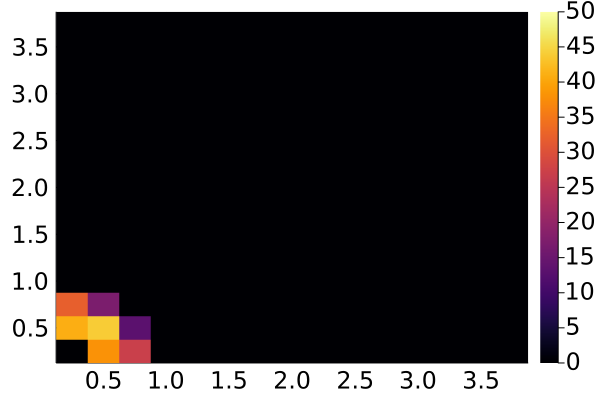

In [31]:
@show infeas_cnt0
infeas_map = infeas_map0[1:15, 1:15]
p = plot(xtickfontsize=16,ytickfontsize=16,xguidefontsize=16,yguidefontsize=16,legendfontsize=16)
heatmap!(p, (1:size(infeas_map,1))*0.25, (1:size(infeas_map,2))*0.25, infeas_map, clim=(0,50))

In [32]:
savefig("../results/heatmap0.png")

In [12]:
infeas_cnt1, infeas_states1, infeas_map1 = find_infeas_states([0.1, 5, 2, 1]);

infeas_cnt1 = 354.0


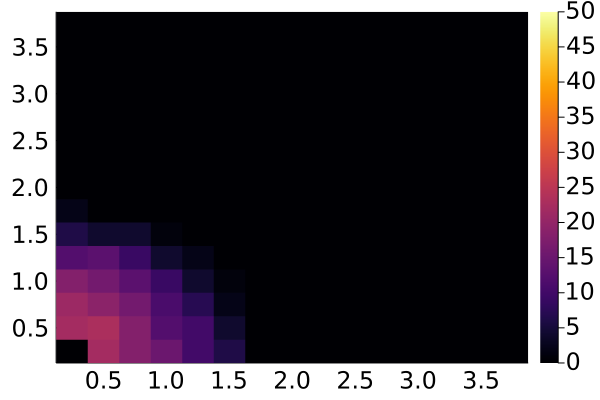

In [13]:
@show infeas_cnt1
infeas_map = infeas_map1[1:15, 1:15]
p = plot(xtickfontsize=16,ytickfontsize=16,xguidefontsize=16,yguidefontsize=16,legendfontsize=16)
heatmap!(p, (1:size(infeas_map,1))*0.25, (1:size(infeas_map,2))*0.25, infeas_map, clim=(0,50))

In [14]:
savefig("../results/heatmap1.png")

In [51]:
infeas_cnt2, infeas_states2, infeas_map2 = find_infeas_states([0.447308, 5.0, 0.1724, 4.10789]);

infeas_cnt2 = 0.0


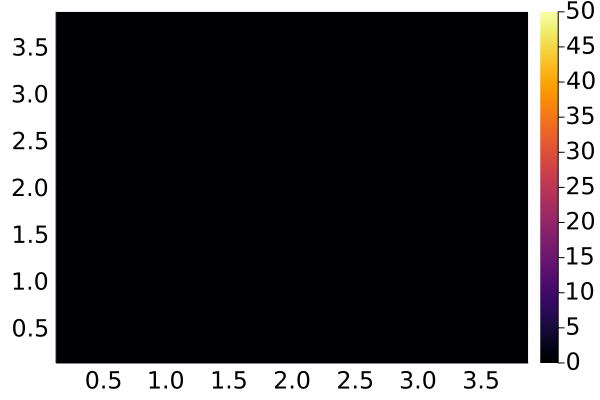

In [52]:
@show infeas_cnt2
infeas_map = infeas_map2[1:15, 1:15]
p = plot(xtickfontsize=16,ytickfontsize=16,xguidefontsize=16,yguidefontsize=16,legendfontsize=16)
heatmap!(p, (1:size(infeas_map,1))*0.25, (1:size(infeas_map,2))*0.25, infeas_map, clim=(0,50))

In [35]:
savefig("../results/heatmap2.png")

In [39]:
function collision_stat(num, ci; ctrl=nothing, verbose=false)
    Random.seed!(127)
    success = 0
    phi0_vio_cnt = 0
    infeas_cnt = 0
    j = 0
    while j < num
        j += 1
        x0 = [0,-2.5+rand(),rand()*4-2,π/2+rand()*π/2-π/4]
        xg = [0,5,0,-π]
        obstacles = [Obstacle([0, rand()-0.5], [0, 0], obs_radius)]
        p = phi(ci, x0, obstacles[1])
        # @show x0, p
        if p > 0
            j -= 1
            continue
        end
        obj_cost = [1,1,1,0.1]
        rp = RP(net, obj_cost, x0, xg)
        ctrl = isnothing(ctrl) ? ShootingController(1000) : ctrl
        Xtrack, Utrack, safe_sets, Xrefs, infeas = tracking(rp, ctrl, fps=10, tf=5, obstacles=obstacles, safety_index=ci, verbose=false);
        infeas_cnt += infeas
        vio=false
        for obs in obstacles
            for x in Xtrack
                if norm(x[1:2]-obs.center) < obs.radius
                    vio=true
                    break
                end 
            end
        end
        phi0_vio_cnt += vio
        success += 1-(vio|infeas)
        # if !infeas && vio
        #     @show j
        #     println(j)
        #     visualize(Xtrack, xlims = [-2,2], ylims = [-3,3], obstacles=obstacles, fps=10)
        #     println(j)
        #     @show x0, p
        #     break
        # end
        if verbose
            @show j, success, phi0_vio_cnt, infeas_cnt
        end
    end
    return success*1.0/num, phi0_vio_cnt*1.0/num, infeas_cnt*1.0/num
end

collision_stat (generic function with 1 method)

In [42]:
ci = CollisionIndex(0.0, 1e-3, 1, 0)
collision_stat(100, ci)

(0.0, 1.0, 1.0)

In [40]:
ci = CollisionIndex(0.1, 5, 2, 1)
collision_stat(100, ci)

(0.89, 0.0, 0.11)

In [41]:
ci = CollisionIndex(0.447308, 5.0, 0.1724, 4.10789)
collision_stat(100, ci)

(1.0, 0.0, 0.0)